In [2]:
from collections import Counter
from typing import Callable, Dict, Optional

import datetime
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import Dataset, DatasetDict, load_dataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split  # Импортируем train_test_split
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from transformers import AutoTokenizer

# Выбираем устройство для обучения (GPU, если доступен, иначе CPU)
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training and evaluating on device {device}.")

Training and evaluating on device cuda.


In [3]:
def compute_mean_and_std(loader: DataLoader, dim: list, device="cpu") -> tuple[torch.Tensor, torch.Tensor]:
    """
    Вычисление среднего значения и стандартного отклонения в наборе данных.

    Args:
        loader (DataLoader): DataLoader для итерации по набору данных
        dim (list): Размерности, по которым будут считатья значения
        device (str): Устройство, на котором выполняются вычисления ("cpu" или "cuda").

    Returns:
        tuple[torch.Tensor, torch.Tensor]: Кортеж, содержащий тензоры среднего значения и стандартного отклонения.
    """
    # 1 Создаем список из всех тензоров
    inputs_list = []
    for inputs, _ in loader:
        inputs_list.append(inputs)

    # 2 Соединяем все тензоры в один большой тензор
    all_inputs = torch.cat(inputs_list, dim=0).float().to(device)  # Преобразуем в float и перемещаем на устройство

    # 3 Вычисляем mean и std
    mean = torch.mean(all_inputs, dim=dim)
    std = torch.std(all_inputs, dim=dim)

    return mean, std


class ModelEvaluator:
    """
    A class to evaluate a PyTorch model on given datasets.
    """

    def __init__(self, model: nn.Module, device: torch.device, task_type: str):
        """
        Initializes the ModelEvaluator.

        Args:
            model: The PyTorch model to evaluate.
            device: The device to perform evaluation on (e.g., 'cuda' or 'cpu').
            task_type: The type of problem we will be solving ('CV','NLP')
        """
        self.model = model
        self.device = device
        self.task_type = task_type
        
        self.model.to(self.device)  # Move model to the specified device

        available_task_types = ['CV','NLP']
        if self.task_type not in available_task_types:
            raise ValueError(f"task_type can be only: {available_task_types}")

    def evaluate_dataset(self, loader: DataLoader) -> Dict[str, float]:
        """
        Evaluates the model on a given dataset and returns a dictionary of metrics.

        Args:
            loader: The DataLoader for the dataset.

        Returns:
            A dictionary containing evaluation metrics, e.g., {"accuracy": 0.95}.
        """
        self.model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in loader:
                if self.task_type == 'CV':
                    inputs, target = batch
                    inputs = inputs.to(self.device)
                    target = target.to(self.device)
                    outputs = self.model(inputs)
                elif self.task_type == 'NLP':
                    inputs = batch['input_ids'].to(self.device)
                    target = batch['label'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    outputs = self.model(inputs, attention_mask)  # Pass attention mask

                _, predicted = torch.max(outputs, dim=1)  # Get predictions
                correct += (predicted == target).sum().item()  # Count correct predictions
                total += target.size(0)  # Count total number of samples

        accuracy: float = correct / total
        return {"accuracy": accuracy}

    def evaluate(self, train_loader: DataLoader, val_loader: DataLoader) -> Dict[str, Dict[str, float]]:
        """
        Evaluates the model on train and validation datasets and returns a dictionary of metrics.

        Args:
            train_loader: The DataLoader for the training dataset.
            val_loader: The DataLoader for the validation dataset.

        Returns:
            A dictionary containing evaluation metrics for both training and validation datasets,
            e.g., {"train": {"accuracy": 0.90}, "val": {"accuracy": 0.95}}.
        """
        print(f"Evaluating on device {self.device}.")
        metrics = {}
        metrics["train"] = self.evaluate_dataset(train_loader)
        metrics["val"] = self.evaluate_dataset(val_loader)
        return metrics



class Trainer:
    """
    A class to encapsulate the training loop for a PyTorch model.

    Args:
        model: The neural network model to train.
        optimizer: The optimizer to use for training.
        loss_fn: The loss function to use.
        train_loader: The DataLoader for the training data.
        device: The device to train on (CPU or GPU).
        task_type: The type of problem we will be solving ('CV','NLP')
        clip_grad_norm: Optional value to clip gradients to. Defaults to None.
        print_interval:  How often to print the training loss. Defaults to 10.
    """

    def __init__(
        self,
        model: nn.Module,
        optimizer: optim.Optimizer,
        loss_fn: nn.Module,
        train_loader: DataLoader,
        device: torch.device,
        task_type: str,
        clip_grad_norm: Optional[float] = None,
        print_interval: int = 10,
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_loader = train_loader
        self.device = device
        self.task_type = task_type
        self.clip_grad_norm = clip_grad_norm
        self.print_interval = print_interval

        self.model.to(self.device)  # Move the model to the device in the constructor

        available_task_types = ['CV','NLP']
        if self.task_type not in available_task_types:
            raise ValueError(f"task_type can be only: {available_task_types}")

    def train_one_batch(self, inputs: torch.Tensor, target: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> float:
        """Trains the model on a single batch of data.

        Args:
            inputs: The input tensor.
            target: The target tensor.
            attention_mask: The attention mask tensor (for NLP)

        Returns:
            The loss value for the batch.
        """
        self.model.train()  # Ensure the model is in training mode

        self.optimizer.zero_grad(set_to_none=True)  # More efficient if possible

        if attention_mask is None:
            outputs = self.model(inputs)
        else:
            outputs = model(inputs, attention_mask=attention_mask)
        loss = self.loss_fn(outputs, target)

        loss.backward()

        if self.clip_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)  # Gradient clipping

        self.optimizer.step()

        return loss.item()

    def train_epoch(self, epoch_num: int = 0) -> float:
        """Trains the model for one epoch.

        Args:
            epoch_num: The current epoch number (for logging).  Defaults to 0.

        Returns:
            The average loss for the epoch.
        """
        self.model.train()  # Ensure the model is in training mode
        loss_train = 0.0
        num_batches = len(self.train_loader)
        for batch in self.train_loader:
            if self.task_type == 'CV':
                inputs, target = batch
                inputs = inputs.to(self.device)
                target = target.to(self.device)
                loss_train += self.train_one_batch(inputs, target)
            elif self.task_type == 'NLP':
                inputs = batch['input_ids'].to(self.device)
                target = batch['label'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                loss_train += self.train_one_batch(inputs, target, attention_mask)       

        return loss_train / num_batches

    def training_loop(self, n_epochs: int) -> None:
        """Executes the main training loop.

        Args:
            n_epochs: The number of epochs to train for.
        """
        print(f"Training on device {self.device}.")

        for epoch in range(1, n_epochs + 1):
            avg_loss = self.train_epoch(epoch)

            if epoch == 1 or epoch % self.print_interval == 0:
                print(f"{datetime.datetime.now()} Epoch {epoch}, Training loss: {avg_loss:.4f}")

# 1. Computer Vision - CV

In [4]:
# 0 Создаем словарь с классами
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names_dict = dict(zip(range(len(class_names)), class_names))

# 1 Загрузка и подготовка данных (без нормализации), получение Mean и Std
trainset= torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor()
    ]))
# 1.1 создаем dataloader
dataloader = DataLoader(trainset, batch_size=64, shuffle=False, num_workers=2)
# 1.2 считаем mean и std
mean, std = compute_mean_and_std(dataloader, [0,2,3])
print(f"Mean: {mean}")
print(f"Std Dev: {std}")

# 2 Загрузка и подготовка данных (с нормализацией)
trainset = datasets.FashionMNIST(
    root='./data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])) # Тренировочный набор
valset = datasets.FashionMNIST(
    root='./data', train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])) # Валидационный набор

# 3 Создаем dataloders
batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size,
                                         shuffle=False)

# 4 Определяем архитектуру нейронной сети
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,28, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(28,56, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(56*14*14, 112)
        self.fc2 = nn.Linear(112, 10)
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(self.dropout1(x),2)
        x = torch.flatten(x,1)
        x = nn.functional.relu(self.fc1(self.dropout2(x)))
        x = self.fc2(x)
        return x

# 5 Настройка модели, оптимизатора и функции потерь
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

# 6.1 Создание и настройка тренера (Trainer)
task_type = 'CV'
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
    device=device,
    task_type=task_type,
    clip_grad_norm=1.0,
    print_interval=1,
)
# 6.2 Запуск процесса обучения
trainer.training_loop(n_epochs=10)

# 7 Оценка обученной модели
evaluator = ModelEvaluator(model, device, task_type)
metrics = evaluator.evaluate(train_loader, val_loader)
print(metrics)

Mean: tensor([0.2860])
Std Dev: tensor([0.3530])
Training on device cuda.
2025-02-19 18:18:42.583446 Epoch 1, Training loss: 0.5019
2025-02-19 18:18:49.462764 Epoch 2, Training loss: 0.2615
2025-02-19 18:18:56.760571 Epoch 3, Training loss: 0.2338
2025-02-19 18:19:04.282560 Epoch 4, Training loss: 0.2114
2025-02-19 18:19:11.639893 Epoch 5, Training loss: 0.1961
2025-02-19 18:19:18.987156 Epoch 6, Training loss: 0.1803
2025-02-19 18:19:26.302673 Epoch 7, Training loss: 0.1685
2025-02-19 18:19:33.582800 Epoch 8, Training loss: 0.1682
2025-02-19 18:19:40.917454 Epoch 9, Training loss: 0.1576
2025-02-19 18:19:48.209993 Epoch 10, Training loss: 0.1471
Evaluating on device cuda.
{'train': {'accuracy': 0.9628166666666667}, 'val': {'accuracy': 0.9174}}


### Testing

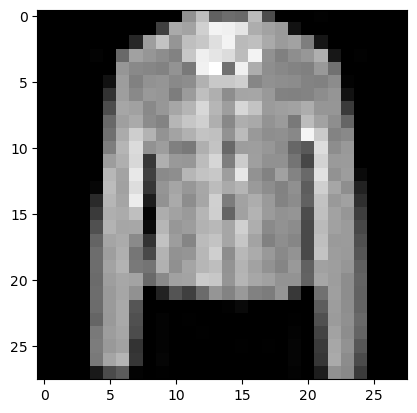


Real answer: Coat
Model answer: Coat

Result:
Model response is correct



In [5]:
number = 10
data, label = valset[number]
plt.imshow(data.squeeze(),cmap='gray')
plt.show()

# predict
model.eval()  # Set the model to evaluation mode
outputs = model(data.to(device).unsqueeze(0))
_, predicted = torch.max(outputs, dim=1)

# validate
real_answer = class_names_dict[label]
model_answer = class_names_dict[predicted.item()]
if real_answer == model_answer:
    result = 'correct'
else:
    result = 'incorrect'
    
print(f"""
Real answer: {real_answer}
Model answer: {model_answer}

Result:
Model response is {result}
""")

# 2. Natural Language Processing (NLP) 

In [6]:
# 0 Создаем словарь с классами
class_names = ['Negative','Positive']
class_names_dict = dict(zip(range(len(class_names)), class_names))

def tokenize_dataset(dataset):
    # 2. Инициализация токенизатора (использовал BERT)
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    # 4. Функция для токенизации и подготовки данных
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
    # 5. Токенизация всего датасета
    tokenized_dataset = dataset.map(tokenize_function, batched=True)

    tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    return tokenized_dataset    

# 1. Загрузка данных и создание Dataloader
batch_size = 64
# 1.1 Train
trainset = load_dataset("imdb", split="train", cache_dir="./data")
train_loader = DataLoader(tokenize_dataset(trainset), batch_size=batch_size, shuffle=True)
# 1.2 Test
valset = load_dataset("imdb", split="test", cache_dir="./data")
val_loader = DataLoader(tokenize_dataset(valset), batch_size=batch_size, shuffle=False)

# 2. Определение модели (LSTM)
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=lstm_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim * 2, num_classes)  # * 2 because bidirectional

    def forward(self, input_ids, attention_mask):  # attention_mask is used but not directly in lstm
        embedded = self.embedding(input_ids) # [batch_size, seq_len, embedding_dim]
        # lstm expects input in the shape (batch_size, seq_len, input_size)

        lstm_out, _ = self.lstm(embedded)  # lstm_out: [batch_size, seq_len, hidden_dim * num_directions]
        # take the output of the last time step for each sequence.
        # In bidirectional LSTM, the output is a concatenation of the forward and backward hidden states

        # Average pooling over the sequence length
        pooled_output = torch.mean(lstm_out, dim=1)  # [batch_size, hidden_dim * 2]  (Average over sequence)

        pooled_output = self.dropout(pooled_output)
        logits = self.linear(pooled_output)
        return logits

# 3. Параметры модели
vocab_size = AutoTokenizer.from_pretrained('bert-base-uncased').vocab_size  # BERT vocab size (bert-base-uncased)
embedding_dim = 128
hidden_dim = 64 
num_classes = 2
lstm_layers = 2 
dropout = 0.5

# 5 Настройка модели, оптимизатора и функции потерь
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

# 6.1 Создание и настройка тренера (Trainer)
task_type = 'NLP'
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
    device=device,
    task_type=task_type,
    clip_grad_norm=1.0,
    print_interval=1,
)
# 6.2 Запуск процесса обучения
trainer.training_loop(n_epochs=10)

# 7 Оценка обученной модели
evaluator = ModelEvaluator(model, device, task_type)
metrics = evaluator.evaluate(train_loader, val_loader)
print(metrics)

Training on device cuda.
2025-02-19 18:20:13.334561 Epoch 1, Training loss: 0.6928
2025-02-19 18:20:16.489710 Epoch 2, Training loss: 0.6635
2025-02-19 18:20:19.793391 Epoch 3, Training loss: 0.5458
2025-02-19 18:20:22.976454 Epoch 4, Training loss: 0.4812
2025-02-19 18:20:26.145222 Epoch 5, Training loss: 0.4412
2025-02-19 18:20:29.294574 Epoch 6, Training loss: 0.4045
2025-02-19 18:20:32.487872 Epoch 7, Training loss: 0.3762
2025-02-19 18:20:35.668688 Epoch 8, Training loss: 0.3575
2025-02-19 18:20:38.857502 Epoch 9, Training loss: 0.3373
2025-02-19 18:20:42.052248 Epoch 10, Training loss: 0.3161
Evaluating on device cuda.
{'train': {'accuracy': 0.88264}, 'val': {'accuracy': 0.83596}}


### Testing

In [7]:
number = 10
data = valset[number]
print(data['text'])
dataset_dict = {
    "text": [data["text"]], 
    "label": [data["label"]]}
single_dataset = Dataset.from_dict(dataset_dict)
single_dataset = tokenize_dataset(single_dataset)

inputs = single_dataset['input_ids'].to(device)
target = single_dataset['label'].to(device)
attention_mask = single_dataset['attention_mask'].to(device)

# predict
model.eval()  # Set the model to evaluation mode
outputs = model(inputs, attention_mask)
_, predicted = torch.max(outputs, dim=1)

# validate
real_answer = class_names_dict[int(target[0])]
model_answer = class_names_dict[int(predicted[0])]
if real_answer == model_answer:
    result = 'correct'
else:
    result = 'incorrect'
    
print(f"""
Real answer: {real_answer}
Model answer: {model_answer}

Result:
Model response is {result}
""")

This flick is a waste of time.I expect from an action movie to have more than 2 explosions and some shooting.Van Damme's acting is awful. He never was much of an actor, but here it is worse.He was definitely better in his earlier movies. His screenplay part for the whole movie was probably not more than one page of stupid nonsense one liners.The whole dialog in the film is a disaster, same as the plot.The title "The Shepherd" makes no sense. Why didn't they just call it "Border patrol"? The fighting scenes could have been better, but either they weren't able to afford it, or the fighting choreographer was suffering from lack of ideas.This is a cheap low type of action cinema.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]


Real answer: Negative
Model answer: Negative

Result:
Model response is correct



# Tabular Data

In [8]:

from torch.utils.data import DataLoader, Dataset, random_split


# 0 Создаем словарь с классами
class_names = ['setosa', 'versicolor', 'virginica']
class_names_dict = dict(zip(range(len(class_names)), class_names))

# 1. Загрузка и подготовка данных
iris = load_iris()
iris_data = iris['data']
iris_target = iris['target']

# 2. Разделение на train и val
train_data, val_data, train_target, val_target = train_test_split(
    iris_data, iris_target, test_size=0.2, random_state=42
)

# 3. Нормализация данных (StandardScaler)
scaler = StandardScaler()
train_data_normalized = scaler.fit_transform(train_data)
val_data_normalized = scaler.transform(val_data)

# 4. Создание кастомного Dataset
class IrisDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data.astype(np.float32)
        self.targets = targets.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.targets[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

# 5. Создание Dataset
trainset = IrisDataset(train_data_normalized, train_target)
valset = IrisDataset(val_data_normalized, val_target)

# 5. Создание DataLoaders
batch_size = 32
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# 4 Определяем архитектуру нейронной сети
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 8) # 4 входных признака, 10 нейронов в первом слое
        self.fc2 = nn.Linear(8, 16) # 4 входных признака, 10 нейронов в первом слое
        self.fc3 = nn.Linear(16, 3) # 10 нейронов, 3 выходных класса

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 5 Настройка модели, оптимизатора и функции потерь
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

# 6.1 Создание и настройка тренера (Trainer)
task_type = 'CV'
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
    device=device,
    task_type=task_type,
    clip_grad_norm=1.0,
    print_interval=1,
)
# 6.2 Запуск процесса обучения
trainer.training_loop(n_epochs=10)

# 7 Оценка обученной модели
evaluator = ModelEvaluator(model, device, task_type)
metrics = evaluator.evaluate(train_loader, val_loader)
print(metrics)


Training on device cuda.
2025-02-19 18:20:44.809687 Epoch 1, Training loss: 1.0292
2025-02-19 18:20:44.818194 Epoch 2, Training loss: 0.9183
2025-02-19 18:20:44.825193 Epoch 3, Training loss: 0.7900
2025-02-19 18:20:44.833698 Epoch 4, Training loss: 0.6493
2025-02-19 18:20:44.841709 Epoch 5, Training loss: 0.5306
2025-02-19 18:20:44.850213 Epoch 6, Training loss: 0.4577
2025-02-19 18:20:44.857721 Epoch 7, Training loss: 0.3950
2025-02-19 18:20:44.863721 Epoch 8, Training loss: 0.3419
2025-02-19 18:20:44.870231 Epoch 9, Training loss: 0.2898
2025-02-19 18:20:44.876793 Epoch 10, Training loss: 0.2436
Evaluating on device cuda.
{'train': {'accuracy': 0.9333333333333333}, 'val': {'accuracy': 0.9333333333333333}}


### Testing

In [9]:
number = 10
data, label = valset[number]
print(data)

# predict
model.eval()  # Set the model to evaluation mode
data = torch.from_numpy(data).float()
outputs = model(data.to(device).unsqueeze(0))
_, predicted = torch.max(outputs, dim=1)

# validate
real_answer = class_names_dict[label]
model_answer = class_names_dict[predicted.item()]
if real_answer == model_answer:
    result = 'correct'
else:
    result = 'incorrect'
    
print(f"""
Real answer: {real_answer}
Model answer: {model_answer}

Result:
Model response is {result}
""")

[0.8421045 0.3092991 0.7869979 1.0901277]

Real answer: virginica
Model answer: virginica

Result:
Model response is correct



# Time Series Analysis

### Testing

# Clustering

### Testing